# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [2]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 31.54 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16678 sha256=30a66bc1653a5c17eac76aede5504275c81b36692f61a121197c538e112a04d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-flyj8l04/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul


In [3]:
from deepul.hw1_helper import *

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


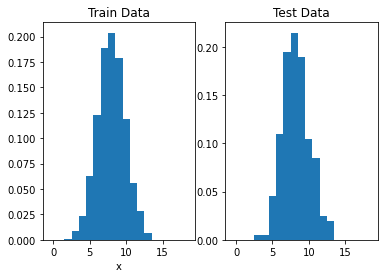

Dataset 2


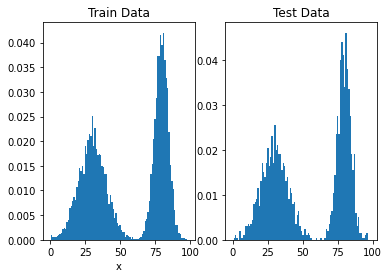

In [4]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^d$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [70]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class HistogramModel(nn.Module):
  def __init__(self, d, device):
    super().__init__()
    self.device = device
    self.d = d
    self.logit = nn.Parameter(torch.zeros(d), requires_grad=True)
  
  def loss(self, x):
    logits = torch.cat(x.size(0) * [self.logit.unsqueeze(0)])
    return F.cross_entropy(logits, x.long())
  
  def dist(self):
    return F.softmax(self.logit, dim=0).detach().cpu().numpy()


def train_single_epoch(model, data, optimizer, device):
    model.train()

    losses = []
    for x in data:
      loss = model.loss(x.to(device))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
    return losses


def eval_model(model, data, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
      for x in data:
        total_loss += model.loss(x.to(device)).item() * x.size(0)
    return total_loss / len(data.dataset)

In [466]:
def train_model(model, train_data, test_data, dset_id, device, epochs, lr):
  dataloader_train = data.DataLoader(train_data, 64, shuffle=True)
  dataloader_test = data.DataLoader(test_data, 64)
  train_loss_list = []
  test_loss_list = []

  optimizer = optim.Adam(model.parameters(), lr=lr)
  for ep in range(epochs):
    train_loss = train_single_epoch(model, dataloader_train, optimizer, device)
    train_loss_list = train_loss_list + train_loss

    test_loss = eval_model(model, dataloader_test, device)
    test_loss_list.append(test_loss)
    print('loss:', test_loss, 'at epoch', ep)
  
  return train_loss_list, test_loss_list, model.dist()

In [467]:
def q1_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = HistogramModel(d, device).to(device)
  return train_model(
      model, 
      train_data, 
      test_data, 
      dset_id,
      device,
      epochs=20,
      lr=2e-2
  )

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



loss: 2.73610538482666 at epoch 0
loss: 2.5334075450897218 at epoch 1
loss: 2.391360206604004 at epoch 2
loss: 2.294431962966919 at epoch 3
loss: 2.2294094657897947 at epoch 4
loss: 2.186280527114868 at epoch 5
loss: 2.1583085536956785 at epoch 6
loss: 2.138985819816589 at epoch 7
loss: 2.1245163440704347 at epoch 8
loss: 2.1157731914520266 at epoch 9
loss: 2.107229166030884 at epoch 10
loss: 2.0994176483154297 at epoch 11
loss: 2.095806155204773 at epoch 12
loss: 2.091473412513733 at epoch 13
loss: 2.087902512550354 at epoch 14
loss: 2.085927686691284 at epoch 15
loss: 2.084509406089783 at epoch 16
loss: 2.0814567899703977 at epoch 17
loss: 2.0780001878738403 at epoch 18
loss: 2.0771708345413207 at epoch 19
Final Test Loss: 2.0772


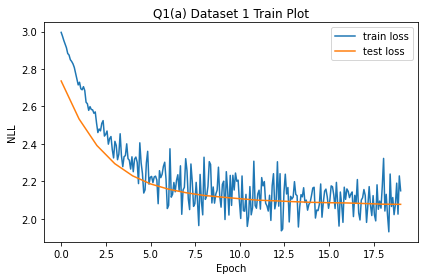

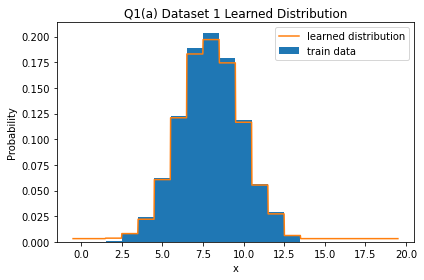

In [468]:
q1_save_results(1, 'a', q1_a)

loss: 4.068460018157959 at epoch 0
loss: 4.043418357849121 at epoch 1
loss: 4.034657409667969 at epoch 2
loss: 4.034881797790527 at epoch 3
loss: 4.034437217712402 at epoch 4
loss: 4.032333644866943 at epoch 5
loss: 4.033641674041748 at epoch 6
loss: 4.034441425323486 at epoch 7
loss: 4.033886322021484 at epoch 8
loss: 4.034540630340576 at epoch 9
loss: 4.034829616546631 at epoch 10
loss: 4.034320018768311 at epoch 11
loss: 4.033594177246094 at epoch 12
loss: 4.03463916015625 at epoch 13
loss: 4.03368635559082 at epoch 14
loss: 4.036746772766113 at epoch 15
loss: 4.032971286773682 at epoch 16
loss: 4.035039123535157 at epoch 17
loss: 4.032419437408447 at epoch 18
loss: 4.033395668029785 at epoch 19
Final Test Loss: 4.0334


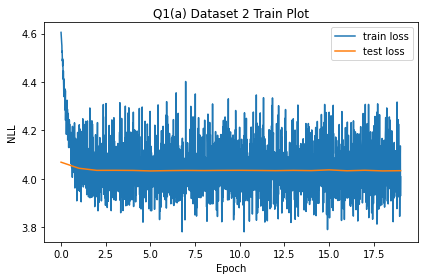

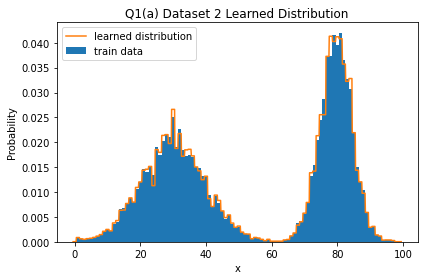

In [469]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = d-1$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [470]:
class MixtureModel(nn.Module):
  def __init__(self, d, device, mix_num=4):
    super().__init__()
    self.d = d
    self.device = device
    self.mix_num = mix_num
    self.logit = nn.Parameter(torch.zeros(self.mix_num), requires_grad=True)

    self.mean = nn.Parameter(
        torch.arange(self.mix_num).float() / (self.mix_num - 1) * self.d, 
        requires_grad=True
    )

    self.log_sigma = nn.Parameter(
        torch.randn(self.mix_num), 
        requires_grad=True
    )

  def forward(self, x):
    return self.forward_helper(x)
  
  def forward_helper(self, x):
    x = x.float().unsqueeze(1)
    x = x.repeat(1, self.mix_num)
    mean = self.mean.unsqueeze(0)
    inv_sigma = torch.exp(-self.log_sigma.unsqueeze(0))

    cdf_first = torch.sigmoid((x + 0.5 - mean) * inv_sigma)
    cdf_second = torch.sigmoid((x - 0.5 - mean) * inv_sigma)
    cdf = cdf_first - cdf_second

    log_cdf = torch.log(torch.clamp(cdf, min=1e-12))

    cdf_first_zero = torch.sigmoid((0.5 - mean) * inv_sigma)
    log_cdf_first = torch.log(torch.clamp(cdf_first_zero, min=1e-12))

    cdf_second_zero = 1 - torch.sigmoid((self.d - 1.5 - mean) * inv_sigma)
    log_cdf_second = torch.log(torch.clamp(cdf_second_zero, min=1e-12))

    log_cdf = torch.where(
        x < 0.001,
        log_cdf_first,
        torch.where(
            x > self.d - 1 - 1e-3,
            log_cdf_second,
            log_cdf
        )
    )

    pi_log_probs = F.log_softmax(self.logit, dim=0).unsqueeze(0)
    log_probs = log_cdf + pi_log_probs
    return torch.logsumexp(log_probs, dim=1)
  
  def loss(self, x):
    x = self.forward_helper(x)
    return -torch.mean(x)
  
  def dist(self):
    with torch.no_grad():
      x = torch.arange(self.d).float().to(self.device)
      dist = torch.exp(self.forward_helper(x))
      return dist.detach().cpu().numpy()

In [471]:
def q1_b(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test,) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for random variable x
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d,) of model probabilities
  """
  
  """ YOUR CODE HERE """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = MixtureModel(d, device, mix_num=4).to(device)
  return train_model(
      model, 
      train_data, 
      test_data,  
      dset_id,
      device,
      epochs=20,
      lr=2e-2
  )

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



loss: 2.8238399982452393 at epoch 0
loss: 2.6190147304534914 at epoch 1
loss: 2.4564130973815916 at epoch 2
loss: 2.324763412475586 at epoch 3
loss: 2.2360598182678224 at epoch 4
loss: 2.183152799606323 at epoch 5
loss: 2.150889792442322 at epoch 6
loss: 2.1301137924194338 at epoch 7
loss: 2.115824007987976 at epoch 8
loss: 2.1067211866378783 at epoch 9
loss: 2.0993754291534423 at epoch 10
loss: 2.093336582183838 at epoch 11
loss: 2.088227376937866 at epoch 12
loss: 2.086278557777405 at epoch 13
loss: 2.08211706161499 at epoch 14
loss: 2.078697690963745 at epoch 15
loss: 2.076189637184143 at epoch 16
loss: 2.0733947467803957 at epoch 17
loss: 2.0717774868011474 at epoch 18
loss: 2.0719411754608155 at epoch 19
Final Test Loss: 2.0719


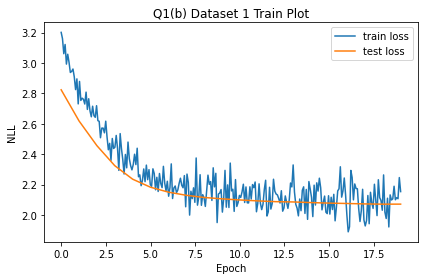

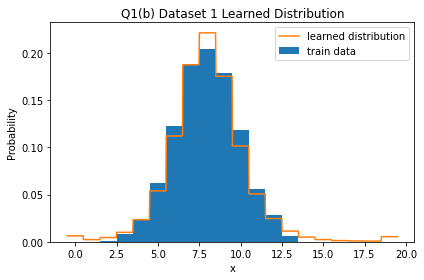

In [472]:
q1_save_results(1, 'b', q1_b)

loss: 5.031187477111817 at epoch 0
loss: 4.599624614715577 at epoch 1
loss: 4.475840057373047 at epoch 2
loss: 4.422493087768554 at epoch 3
loss: 4.374430042266845 at epoch 4
loss: 4.305859233856201 at epoch 5
loss: 4.216807456970215 at epoch 6
loss: 4.116314094543457 at epoch 7
loss: 4.055661067962647 at epoch 8
loss: 4.041422241210937 at epoch 9
loss: 4.039449348449707 at epoch 10
loss: 4.038757350921631 at epoch 11
loss: 4.039176418304443 at epoch 12
loss: 4.038933731079101 at epoch 13
loss: 4.039114356994629 at epoch 14
loss: 4.0386599349975585 at epoch 15
loss: 4.039886180877685 at epoch 16
loss: 4.038447750091553 at epoch 17
loss: 4.038903728485107 at epoch 18
loss: 4.0388100128173825 at epoch 19
Final Test Loss: 4.0388


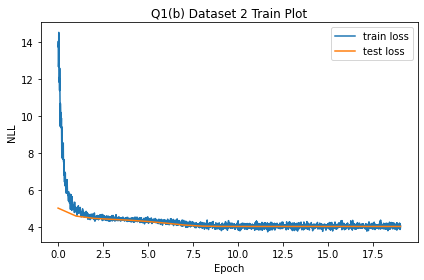

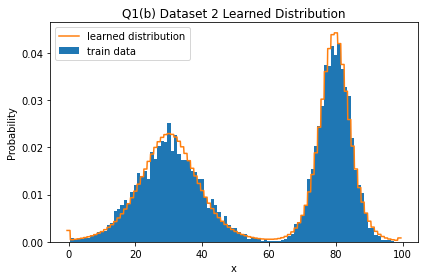

In [473]:
q1_save_results(2, 'b', q1_b)

# Question 2: MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


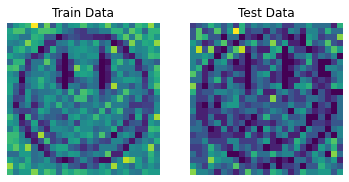

Dataset 2


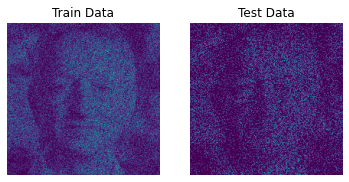

In [474]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [555]:
def to_onehot(labels, d, device):
  one_hot = torch.zeros(labels.shape[0], d).to(device)
  one_hot.scatter_(1, labels.unsqueeze(1), 1)
  return one_hot


class MaskedLinear(nn.Module):
  def __init__(self, num_input_feat, in_feat, out_feat, bias=True):
    super().__init__()

    self.num_input_feat = num_input_feat
    self.out_feat = out_feat
    self.order = torch.arange(out_feat).type(torch.int32)
    self.fc = nn.Linear(in_feat, out_feat, bias)
    self.register_buffer(
        "mask", torch.ones_like(self.fc.weight).type(torch.uint8)
    )

  def set_mask(self, prev_order):
      self.mask[...] = (prev_order[:, None] <= self.order[None, :]).T

  def forward(self, x):
      if self.fc.bias is None:
          b = 0
      else:
          b = self.fc.bias

      return F.linear(x, self.fc.weight * self.mask, b)


class Network(nn.Module):
  def __init__(self, num_input_feat, in_, h1, h2, h3, out_):
    super().__init__()
    self.num_input_feat = num_input_feat
    self.fc1 = MaskedLinear(num_input_feat, in_feat=in_, out_feat=h1)
    self.fc2 = MaskedLinear(num_input_feat, in_feat=h1, out_feat=h2)
    self.fc3 = MaskedLinear(num_input_feat, in_feat=h2, out_feat=h3)
    self.fc4 = MaskedLinear(num_input_feat, in_feat=h3, out_feat=out_)
    self.actv = nn.ReLU()

    self.set_masks()
    # for l in [self.fc1, self.fc2, self.fc3, self.fc4]:
    #   print(l.order)
    #   print(l.mask)
    #   print()

  
  def set_masks(self):
    self.set_mask_input_layer(self.fc1)
    self.set_mask_hidden_layer(self.fc2, self.fc1)
    self.set_mask_hidden_layer(self.fc3, self.fc2)
    self.set_mask_output_layer(self.fc4, self.fc3)
  
  def set_mask_hidden_layer(self, layer, prev_layer):
    layer.order = torch.randint(prev_layer.order.min(), self.num_input_feat - 1, size=(layer.out_feat,))
    layer.set_mask(prev_layer.order)
  
  def set_mask_output_layer(self, layer, prev_layer):
    layer.order = torch.arange(layer.num_input_feat)
    layer.set_mask(prev_layer.order)
  
  def set_mask_input_layer(self, layer):
    order = torch.arange(1, layer.num_input_feat + 1)
    order[-1] = 1e9
    layer.set_mask(order)
  
  def forward(self, x):
    x = self.actv(self.fc1(x))
    x = self.actv(self.fc2(x))
    x = self.actv(self.fc3(x))
    return self.fc4(x)


class MADE(nn.Module):
  def __init__(self, in_shape, d, onehot, device, hid_sizes=[128, 128, 128]):
    super().__init__()
    self.in_shape = in_shape
    self.in_dim = np.prod(in_shape)
    self.out_dim = self.in_dim * d
    self.device = device
    self.d = d
    self.onehot = onehot
    h0 = self.in_dim
    if self.onehot:
      h0 *= self.d
    self.network = Network(h0, h0, *hid_sizes, self.out_dim)

  def forward(self, x):
    return self.forward_helper(x)

  def forward_helper(self, x):
    batch_size = x.size(0)
    if self.onehot:
      x = x.long().contiguous().view(-1)
      x = to_onehot(x, self.d, self.device)
      x = x.view(batch_size, -1)
    else:
      x = x.float()
      x = x.view(batch_size, self.in_dim)
    logits = self.network(x).view(batch_size, self.in_dim, self.d)
    return logits.permute(0, 2, 1).view(batch_size, self.d, *self.in_shape)
  
  def loss(self, x):
      return F.cross_entropy(self.forward_helper(x), x.long())
    
  def dist(self):
    x = np.mgrid[:self.d, :self.d].reshape(2, self.d * self.d).T
    x = torch.LongTensor(x).to(self.device)
    log_probs = F.log_softmax(self.forward_helper(x), dim=1)
    x = x.unsqueeze(1)
    dist = torch.gather(log_probs, 1, x).squeeze(1)
    dist = dist.sum(dim=1)
    return dist.exp().view(self.d, self.d).detach().cpu().numpy()

In [556]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  """ YOUR CODE HERE """
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = MADE((2,), d, True, device).to(device)
  return train_model(
      model, 
      train_data, 
      test_data,  
      dset_id,
      device,
      epochs=5,
      lr=1e-3
  )

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



In [557]:
q2_save_results(1, 'a', q2_a)

loss: 3.2076623077392576 at epoch 0
loss: 2.824014114379883 at epoch 1
loss: 2.364614850997925 at epoch 2
loss: 2.05803883934021 at epoch 3
loss: 1.8297567739486695 at epoch 4


AssertionError: ignored

(2,) 2 200 400
loss: 5.276589961242676 at epoch 0
loss: 5.275187794494629 at epoch 1
loss: 5.274989866638184 at epoch 2
loss: 5.274854533386231 at epoch 3
loss: 5.274747956848144 at epoch 4
loss: 5.274458675384522 at epoch 5
loss: 5.274483679962159 at epoch 6
loss: 5.274595275878906 at epoch 7
loss: 5.27445319442749 at epoch 8
loss: 5.274339138031006 at epoch 9
loss: 5.274536054992676 at epoch 10
loss: 5.274161714172363 at epoch 11
loss: 5.274446858978272 at epoch 12
loss: 5.27397873840332 at epoch 13
loss: 5.273931095886231 at epoch 14
loss: 5.273900553894043 at epoch 15
loss: 5.274305261993408 at epoch 16
loss: 5.274050064849853 at epoch 17
loss: 5.274009166717529 at epoch 18
loss: 5.273715158843994 at epoch 19
Final Test Loss: 5.2737


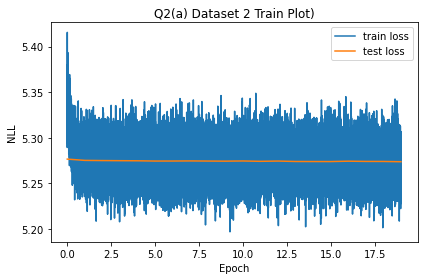

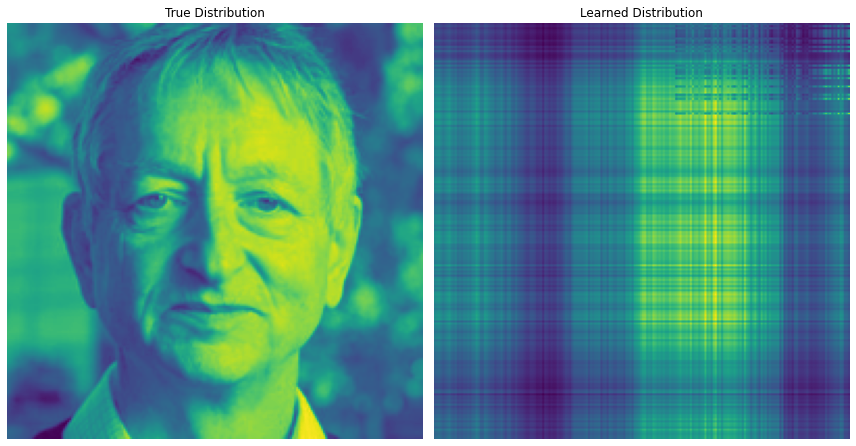

In [507]:
q2_save_results(2, 'a', q2_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

In [ ]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0623


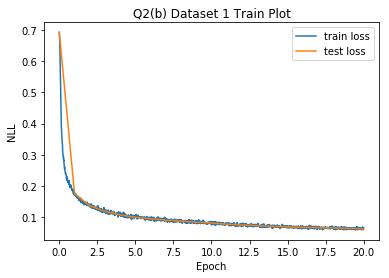

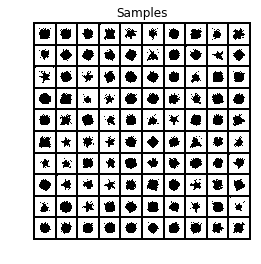

In [ ]:
q2_save_results(1, 'b', q2_b)

In [ ]:
q2_save_results(2, 'b', q2_b)

# Question 3 PixelCNNs

Now, you will train more powerful PixleCNN models on the shapes dataset and MNIST. In addition, we will extend to modelling colored datasets with and without channel conditioning.



## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_a(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.0420


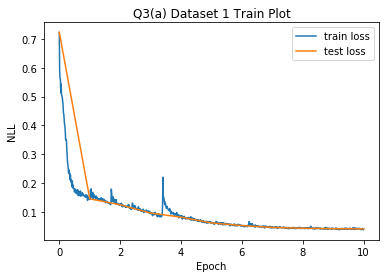

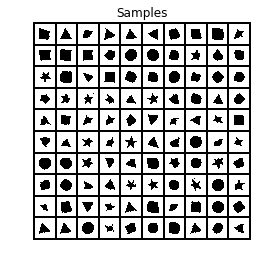

In [ ]:
q3a_save_results(1, q3_a)

In [ ]:
q3a_save_results(2, q3_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next two parts, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

In [ ]:
visualize_q3b_data(1)
visualize_q3b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0444


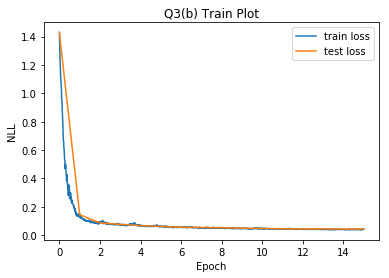

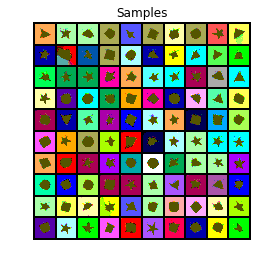

In [ ]:
q3bc_save_results(1, 'b', q3_b)

In [ ]:
q3bc_save_results(2, 'b', q3_b)

## Part (c) PixelCNN on Colored Shapes and MNIST: Autoregressive Color Channels

Now, implement a PixelCNN that models **dependent** color channels. Formally, we model the parameterized distribution

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_i^{<c}, x_{<i})$$

To do so, change your masking scheme for the center pixel. Split the filters into 3 groups, only allowing each group to see the groups before (or including the current group, for type B masks) to maintain the autoregressive property.

Training times and hyperparameter settings should be the same as part (b).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_c(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



Final Test Loss: 0.0236


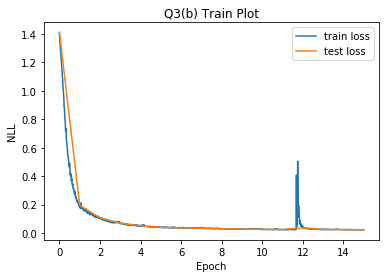

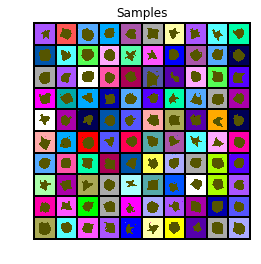

In [ ]:
q3bc_save_results(1, 'c', q3_c)

In [ ]:
q3bc_save_results(2, 'c', q3_c)

## Part (d) Conditional PixelCNNs

In this part, implement and train a **class-conditional** PixelCNN on binary MNIST. Condition on a class label by adding a conditional bias in each convolutional layer. More precisely, in the $\ell$th convolutional layer, compute: 
$$W_\ell * x + b_\ell + V_\ell y$$
where $W_\ell * x + b_\ell$ is a masked convolution (as in previous parts), $V$ is a 2D weight matrix, and $y$ is a one-hot encoding of the class label (where the conditional bias is broadcasted spacially and added channel-wise).

You can use a PixelCNN architecture similar to part (a). Training on the shapes dataset should be quick, and MNIST should take around 10-15 minutes


**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q3_d`, execute the cells below to visualize and save your results



Final Test Loss: 0.0368


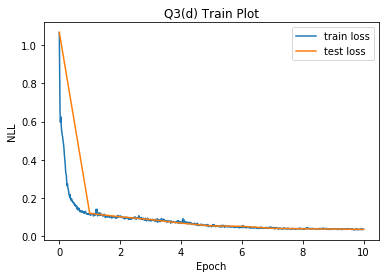

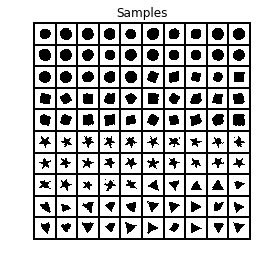

In [ ]:
q3d_save_results(1, q3_d)

In [ ]:
q3d_save_results(2, q3_d)

# Question 4: Bonus Questions (Optional)

## Part (a) Gated PixelCNN
Implement a [Gated PixelCNN](https://arxiv.org/abs/1606.05328) to fix the blind-spot issue, and report training curves, final test loss, and samples.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_a(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, C) of generated samples with values in {0, 1, 2, 3}
  """
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_a`, execute the cells below to visualize and save your results



In [ ]:
q4a_save_results(q4_a)

## Part (b) Grayscale PixelcNN
Train a [Grayscale PixelCNN](https://arxiv.org/abs/1612.08185) on Colored MNIST. You do not need to use their architecture - stacking standard masked convolutions or residual blocks is fine. First, generate a binary image, and then the 2-bit color image.

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_b(train_data, test_data, image_shape):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: (H, W, C), height, width, and # of channels of the image

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (50, H, W, 1) of generated binary images in {0, 1}
  - a numpy array of size (50, H, W, C) of conditonally generated color images in {0, 1, 2, 3}
  """
  # You will need to generate the binary image dataset from train_data and test_data
  
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [ ]:
q4b_save_results(q4_b)

## Part (c) Parallel Multiscale PixelCNN
One large disadvantage of autoregressive models is their slow sampling speed, since they require one network evaluation per feature. However, there are existing methods which introduce different independence assumptions to allow for parallelism when sampling. Implement a [Parallel PixelCNN](https://arxiv.org/abs/1703.03664) on 56 x 56 MNIST images, with a base size of 7 x 7 and upscaling by a factor of 2. Sampling should be very quick (< 1s). Architectures may vary, but using small PixelCNN implementation similar to previous parts and small ResNets should suffice

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def q4_c(train_data, test_data):
  """
  train_data: A (60000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  test_data: A (10000, 56, 56, 1) numpy array of grayscale images with values in {0, 1}
  image_shape: (H, W), height and width

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, 56, 56, 1) of generated samples with values in {0, 1}
  """
 
  """ YOUR CODE HERE """

### Results

Once you've implemented `q4_c`, execute the cells below to visualize and save your results



In [ ]:
q4c_save_results(q4_c)